In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import random
tf.set_random_seed(777)

### padding & pooling

https://github.com/hunkim/DeepLearningZeroToAll/blob/master/lab-11-0-cnn_basics.ipynb

padding:SAME - zero padding을 통해 input 사이즈와 동일한 output 도출

In [ ]:
img = img.reshape(-1,28,28,1)                                   # data count, width, height, depth (color)

W1 = tf.Variable(tf.random_normal([3, 3, 1, 5], stddev=0.01))   # filter width, height, depth, filter count

conv2d = tf.nn.conv2d(img, W1, strides=[1, 2, 2, 1], padding='SAME')  # stride = 2,2. SAME.  --- output 사이즈가 1/2로 줄어든다.

### mnist basics

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


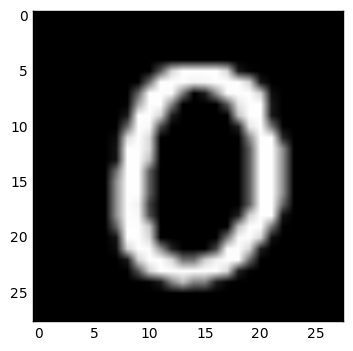

In [4]:
img = mnist.train.images[10].reshape(28,28)
plt.imshow(img, cmap='gray')

Tensor("Conv2D:0", shape=(1, 14, 14, 5), dtype=float32)


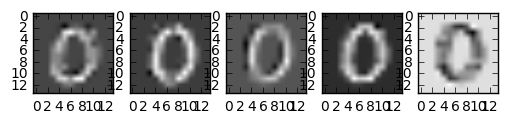

In [5]:
sess = tf.InteractiveSession()

img = img.reshape(-1,28,28,1)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 5], stddev=0.01))
conv2d = tf.nn.conv2d(img, W1, strides=[1, 2, 2, 1], padding='SAME')
print(conv2d)
sess.run(tf.global_variables_initializer())
conv2d_img = conv2d.eval()
conv2d_img = np.swapaxes(conv2d_img, 0, 3)
for i, one_img in enumerate(conv2d_img):
    plt.subplot(1,5,i+1), plt.imshow(one_img.reshape(14,14), cmap='gray')

Tensor("MaxPool:0", shape=(1, 7, 7, 5), dtype=float32)


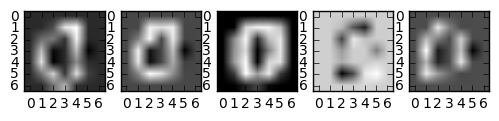

In [6]:
pool = tf.nn.max_pool(conv2d, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print(pool)
sess.run(tf.global_variables_initializer())
pool_img = pool.eval()
pool_img = np.swapaxes(pool_img, 0, 3)
for i, one_img in enumerate(pool_img):
    plt.subplot(1,5,i+1), plt.imshow(one_img.reshape(7, 7), cmap='gray')

### mnist 01

In [5]:
# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [6]:
# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.float32, [None, 10])

In [7]:
# Conv Layer 1

# L1 ImgIn shape=(?, 28, 28, 1)
#    Conv     -> (?, 28, 28, 32)
#    Pool     -> (?, 14, 14, 32)

W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))       # 32개의 3x3 filter
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

'''
Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
'''

'\nTensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)\nTensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)\nTensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)\n'

In [8]:
# Conv Layer 2

# L2 ImgIn shape=(?, 14, 14, 32)
#    Conv      ->(?, 14, 14, 64)
#    Pool      ->(?, 7, 7, 64)

W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
L2_flat = tf.reshape(L2, [-1, 7 * 7 * 64])
'''
Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 3136), dtype=float32)
'''

'\nTensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)\nTensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)\nTensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)\nTensor("Reshape_1:0", shape=(?, 3136), dtype=float32)\n'

In [9]:
# Final FC 7x7x64 inputs -> 10 outputs

# Flatten
W3 = tf.get_variable("W3", shape=[7 * 7 * 64, 10], initializer=tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L2_flat, W3) + b

# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [10]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [11]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 0001 cost = 0.326389088
Epoch: 0002 cost = 0.086197523
Epoch: 0003 cost = 0.064864217
Epoch: 0004 cost = 0.053349301
Epoch: 0005 cost = 0.046424476
Epoch: 0006 cost = 0.039691663
Epoch: 0007 cost = 0.034994727
Epoch: 0008 cost = 0.032544172
Epoch: 0009 cost = 0.026864607
Epoch: 0010 cost = 0.025052323
Epoch: 0011 cost = 0.021415742
Epoch: 0012 cost = 0.019278723
Epoch: 0013 cost = 0.017208282
Epoch: 0014 cost = 0.015655037
Epoch: 0015 cost = 0.012858848
Learning Finished!


In [12]:
# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

Accuracy: 0.9876
